# Question 1:

We do not use the derived full conditional distributions here. Instead, each parameter update uses a Metropolis (M–H) step based on the joint distribution:

$$
p(\theta, \tau \mid x)\; \propto\; \prod_{i=1}^{n}
\Biggl[
   \frac{\tau}{\sqrt{2\pi}}
   \exp\!\Bigl(-\tfrac{\tau^{2}\,(x_i - \theta)^{2}}{2}\Bigr)
\Biggr]
\;\times\;
p(\theta)\,p(\tau),
$$
where we assume the (improper) uniform prior $p(\theta)\propto 1$ on $-\infty < \theta < \infty$ and $p(\tau)\propto 1$ on $\tau>0$. Hence the joint is proportional to
$$
\tau^{\,\tfrac{n}{2}}\;\exp\!\Bigl(-\tfrac{\tau}{2}\,\sum_{i=1}^n (x_i - \theta)^{2}\Bigr),
\quad \tau>0.
$$

---

### Key Steps and Theory

**Metropolis within Gibbs** means we update one parameter at a time ($\theta$ and $\tau$), treating the other as fixed, but we do so via a Metropolis–Hastings step using the *joint* distribution. Even though one *could* derive and sample directly from the full conditionals (standard Gibbs), we bypass that to demonstrate a more general M–H step.

---

#### Proposal Distribution for $\theta$ (Random Walk)

We use a random walk proposal:
$$
\theta^* \sim \mathcal{N}\!\bigl(\,\theta^{(t-1)},\,\sigma_\theta^2\bigr),
$$
where $\sigma_\theta$ is a tuning parameter. The acceptance ratio is:

$$
r \;=\;
\frac{\,p(\theta^*,\,\tau^{(t-1)} \mid x)\;q\bigl(\theta^{(t-1)} \mid \theta^*\bigr)}
     {\,p(\theta^{(t-1)},\,\tau^{(t-1)} \mid x)\;q\bigl(\theta^* \mid \theta^{(t-1)}\bigr)}.
$$

For a *symmetric* proposal $q(a\,|\,b) = q(b\,|\,a)$ (like a normal centered at the previous value), the proposal ratio is 1. Thus,

$$
r \;=\;
\frac{\,p(\theta^*, \tau^{(t-1)})\,}
     {\,p(\theta^{(t-1)}, \tau^{(t-1)})\,},
$$
and we accept $\theta^*$ with probability $\min(1,\,r)$.

---

#### Proposal Distribution for $\tau$ (Independence Sampler)

We require $\tau>0$. One option is to use a Gamma$(\alpha,\beta)$ proposal (or any distribution on $\tau>0$). Let
$$
\tau^* \sim g(\tau)\quad (\text{independent of current }\tau),
$$
where $g(\cdot)$ is a fixed proposal density on $\tau>0$. The acceptance ratio for an *independence* Metropolis–Hastings update is:

$$
r \;=\;
\frac{\,p\bigl(\theta^{(t)}, \tau^* \mid x\bigr)\;g\!\bigl(\tau^{(t-1)}\bigr)}
     {\,p\bigl(\theta^{(t)}, \tau^{(t-1)} \mid x\bigr)\;g\!\bigl(\tau^*\bigr)}.
$$
Then accept $\tau^*$ with probability $\min(1,\,r)$.

---

#### Log Scale

For numerical stability, compute everything on the log scale. We have:

$$
\log p(\theta, \tau \mid x)
\;=\;
\frac{n}{2}\,\log(\tau)
\;-\;
\frac{\tau}{2}\,\sum_{i=1}^n (x_i - \theta)^2
\;+\;
\bigl(\text{constant w.r.t. }\theta,\tau\bigr).
$$
Hence,
$$
\log r
\;=\;
\log p(\theta^*, \tau^*) \;-\; \log p\bigl(\theta^{(t-1)}, \tau^{(t-1)}\bigr)
\;+\;\ldots
$$
for the proposal-density terms.

---

### Demonstration

We generate synthetic data from a Normal$(m, s)$ distribution and then run the Metropolis-within-Gibbs sampler. We visualize the results and compute posterior estimates.



--- Metropolis-within-Gibbs Sampler Results ---
True mean = 5.00, Posterior mean estimate (theta) = 4.919
True std  = 2.00, Posterior std dev estimate = 1.858
95% Credible interval for theta: [4.655, 5.177]
95% Credible interval for tau:   [0.239, 0.347]


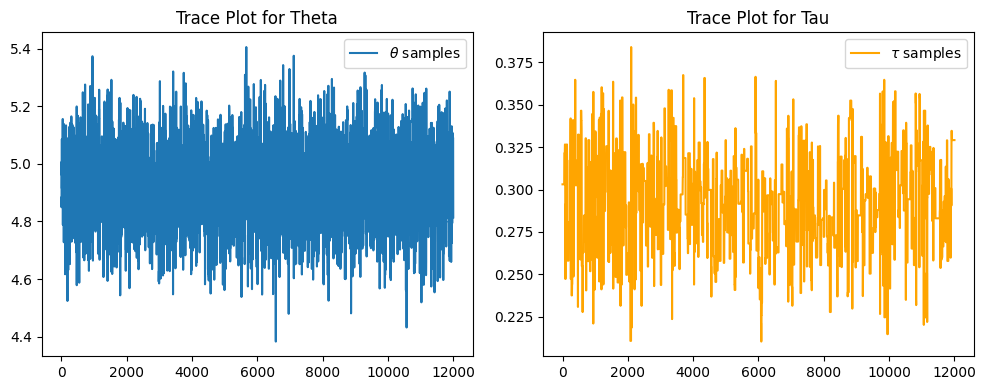

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

def log_joint(theta, tau, x):
    """
    Compute log of the (unnormalized) joint density:
        log p(theta, tau | x) ∝ (n/2)*log(tau) - (tau/2)*sum((x - theta)^2), for tau > 0.
    We omit additive constants that do not depend on theta or tau.
    """
    if tau <= 0:
        return -np.inf  # log(0) if tau <= 0
    n = len(x)
    # sum of squared residuals
    ssr = np.sum((x - theta)**2)
    return (n/2)*np.log(tau) - 0.5 * tau * ssr

def metropolis_within_gibbs_normal_unknown_mean_precision(
    x, n_iter=10000,
    theta_init=0.0,
    tau_init=1.0,
    proposal_std_theta=0.5,
    alpha_tau_proposal=2.0,
    beta_tau_proposal=2.0,
    random_seed=None
):
    """
    Metropolis-within-Gibbs for Normal model with unknown mean (theta) and
    unknown precision (tau). We do not use derived full conditionals; instead,
    each step is a Metropolis–Hastings step based on the joint distribution.

    Args:
        x (array-like): Data values.
        n_iter (int): Number of MCMC iterations.
        theta_init (float): Initial value for theta.
        tau_init (float): Initial value for tau (precision).
        proposal_std_theta (float): Std dev for Normal random-walk proposal of theta.
        alpha_tau_proposal, beta_tau_proposal (float): Shape & rate for Gamma
            distribution used as an independence proposal for tau.
        random_seed (int): For reproducibility (optional).

    Returns:
        thetas (ndarray): MCMC samples for theta.
        taus   (ndarray): MCMC samples for tau (precision).
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    x = np.array(x)
    n = len(x)

    # Arrays to store samples
    thetas = np.zeros(n_iter)
    taus   = np.zeros(n_iter)

    # Initialize
    thetas[0] = theta_init
    taus[0]   = tau_init

    for t in range(1, n_iter):
        current_theta = thetas[t-1]
        current_tau   = taus[t-1]

        # ========================
        # 1) Update theta via Metropolis step
        # ========================
        # Propose theta_star from Normal(current_theta, proposal_std^2)
        theta_star = np.random.normal(loc=current_theta, scale=proposal_std_theta)

        # Compute log joint at proposed and current
        log_p_star    = log_joint(theta_star, current_tau, x)
        log_p_current = log_joint(current_theta, current_tau, x)

        # Symmetric proposal -> proposal ratio = 1, so acceptance ratio is just ratio of joint densities
        log_accept_ratio = log_p_star - log_p_current

        # Accept or reject
        if np.log(np.random.rand()) < log_accept_ratio:
            thetas[t] = theta_star
        else:
            thetas[t] = current_theta

        # ========================
        # 2) Update tau via Metropolis step (independence sampler)
        # ========================
        # Propose tau_star ~ Gamma(alpha_tau_proposal, rate=beta_tau_proposal)
        tau_star = gamma(a=alpha_tau_proposal, scale=1.0/beta_tau_proposal).rvs()

        # log joint for proposed and current
        log_p_star = log_joint(thetas[t], tau_star, x)
        log_p_current = log_joint(thetas[t], current_tau, x)

        # log of proposal densities g(tau)
        #   g(tau) = Gamma(alpha_tau_proposal, beta_tau_proposal)
        # Use shape-rate parametrization: pdf(tau) = beta^alpha / Gamma(alpha) * tau^(alpha-1)* e^{-beta * tau}
        # We'll use SciPy's 'gamma' with scale = 1/beta, so we must do it carefully in log:
        def log_proposal_density(tau_val):
            # log Gamma(alpha, rate=beta) up to constants:
            # alpha * log(beta) - log(Gamma(alpha)) + (alpha - 1)*log(tau_val) - beta*tau_val
            # We can directly use gamma.logpdf(...) for convenience.
            return gamma(a=alpha_tau_proposal, scale=1.0/beta_tau_proposal).logpdf(tau_val)

        log_g_star    = log_proposal_density(tau_star)
        log_g_current = log_proposal_density(current_tau)

        # Metropolis–Hastings ratio
        log_accept_ratio = (log_p_star + log_g_current) - (log_p_current + log_g_star)

        if np.log(np.random.rand()) < log_accept_ratio:
            taus[t] = tau_star
        else:
            taus[t] = current_tau

    return thetas, taus

# ---------------------------
# Demonstration
# ---------------------------
if __name__ == "__main__":
    # Generate synthetic data: Normal(m, s^2) with m=5, s=2
    np.random.seed(42)
    n = 200
    true_mean = 5.0
    true_std  = 2.0
    x = np.random.normal(loc=true_mean, scale=true_std, size=n)

    # Run the Metropolis-within-Gibbs sampler
    n_iter = 15000
    burn_in = 3000

    thetas, taus = metropolis_within_gibbs_normal_unknown_mean_precision(
        x,
        n_iter=n_iter,
        theta_init=0.0,
        tau_init=1.0,
        proposal_std_theta=0.4,   # tune as needed
        alpha_tau_proposal=2.0,
        beta_tau_proposal=2.0,
        random_seed=123
    )

    # Discard burn-in
    thetas_post = thetas[burn_in:]
    taus_post   = taus[burn_in:]

    # Compute posterior estimates
    est_mean   = np.mean(thetas_post)
    est_sigma  = np.mean(1.0 / np.sqrt(taus_post))  # recall tau = 1/sigma^2

    ci_theta_95 = np.percentile(thetas_post, [2.5, 97.5])
    ci_tau_95   = np.percentile(taus_post,   [2.5, 97.5])

    print("\n--- Metropolis-within-Gibbs Sampler Results ---")
    print(f"True mean = {true_mean:.2f}, Posterior mean estimate (theta) = {est_mean:.3f}")
    print(f"True std  = {true_std:.2f}, Posterior std dev estimate = {est_sigma:.3f}")
    print(f"95% Credible interval for theta: [{ci_theta_95[0]:.3f}, {ci_theta_95[1]:.3f}]")
    print(f"95% Credible interval for tau:   [{ci_tau_95[0]:.3f}, {ci_tau_95[1]:.3f}]")

    # Trace plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(thetas_post, label=r'$\theta$ samples')
    axs[0].set_title("Trace Plot for Theta")
    axs[0].legend()

    axs[1].plot(taus_post, label=r'$\tau$ samples', color='orange')
    axs[1].set_title("Trace Plot for Tau")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


# Question 2:
When implementing a Gibbs sampler, the standard procedure involves directly sampling from each full conditional distribution in turn. In many classic or “conjugate” Bayesian models, one can derive simple closed‐form expressions for these full conditionals—which makes ordinary Gibbs trivial to implement. For example, in a normal model with known forms of the priors, the conditional posteriors often fall into well‐known distributions (e.g., Normal, Gamma) that can be sampled from directly.

However, it is not strictly necessary to have such analytically tractable full conditionals. When the full conditionals cannot be derived in closed form or are difficult to sample from even if known, one can embed Metropolis–Hastings steps (or other samplers, e.g., slice sampling) within a Gibbs framework—this is often referred to as Metropolis‐within‐Gibbs. In that approach:

You still update one parameter at a time (like in Gibbs), treating the others as fixed.
Instead of sampling directly from the conditional, you perform a Metropolis–Hastings update targeting the correct conditional distribution.
The acceptance–rejection mechanism guarantees that the joint target posterior distribution remains the stationary distribution of the Markov chain.
Hence, determining the full conditional distributions analytically is a convenience rather than a necessity. If it is relatively straightforward to derive and sample from each full conditional, pure Gibbs is often the simplest and most efficient choice. If not, or if the conditionals are only partially known, more general methods (Metropolis–Hastings, slice sampling, etc.) can handle the sampling step in each parameter update.

In summary:

Gibbs Sampling (Standard): Ideal when you can directly sample from each conditional in closed form.
Metropolis‐within‐Gibbs (or other hybrid approaches): Allows you to proceed without explicitly deriving or directly sampling from the full conditional—ensuring that the chain still converges to the correct posterior distribution.


--- Metropolis-within-Gibbs Sampler Results ---
True mean = 5.00, Posterior mean estimate (theta) = 4.919
True std  = 2.00, Posterior std dev estimate = 1.858
95% Credible interval for theta: [4.655, 5.177]
95% Credible interval for tau:   [0.239, 0.347]


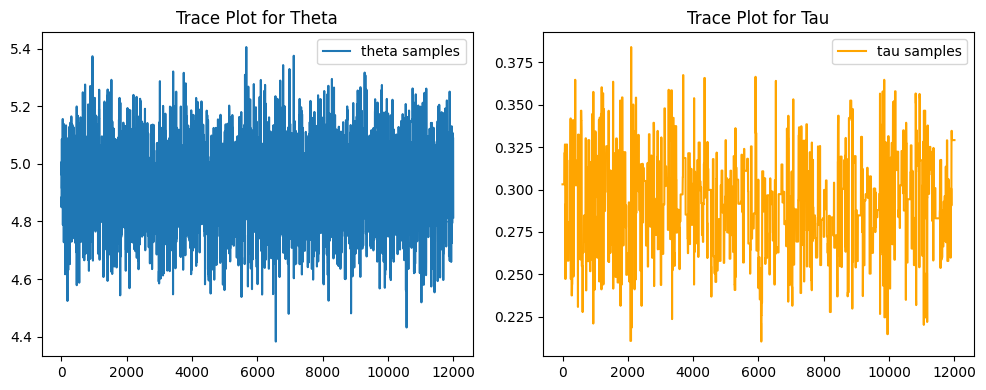

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

def log_joint(theta, tau, x):
    """
    log p(theta, tau | x) ∝ (n/2)*log(tau) - (tau/2)*sum((x - theta)^2),  tau > 0.
    We omit constants that do not depend on theta or tau.
    """
    if tau <= 0:
        return -np.inf
    n = len(x)
    ssr = np.sum((x - theta)**2)  # sum of squared residuals
    return (n / 2.0) * np.log(tau) - 0.5 * tau * ssr

def metropolis_within_gibbs_normal_unknown_mean_precision(
    x, n_iter=10000,
    theta_init=0.0,
    tau_init=1.0,
    proposal_std_theta=0.5,
    alpha_tau_proposal=2.0,
    beta_tau_proposal=2.0,
    random_seed=None
):
    """
    Metropolis-within-Gibbs for Normal model with unknown mean (theta) & precision (tau).
    - We do *not* use full conditionals; each update is a Metropolis–Hastings step using
      the joint distribution p(theta, tau | x).
    - For theta, we use a *random-walk* proposal.
    - For tau, we use an *independence sampler* with a Gamma proposal.

    Args:
        x (array-like): Observed data.
        n_iter (int): Number of MCMC iterations.
        theta_init, tau_init (float): Initial values for parameters.
        proposal_std_theta (float): Std dev in the random-walk proposal for theta.
        alpha_tau_proposal, beta_tau_proposal (float): Shape & rate for Gamma proposal of tau.
        random_seed (int): If set, makes results reproducible.

    Returns:
        thetas (ndarray): MCMC samples for theta.
        taus   (ndarray): MCMC samples for tau.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    x = np.array(x)
    n = len(x)

    thetas = np.zeros(n_iter)
    taus   = np.zeros(n_iter)

    # Initialize
    thetas[0] = theta_init
    taus[0]   = tau_init

    # Helper for log proposal density g(tau)
    #  We'll assume g(tau) is Gamma(alpha_tau_proposal, rate=beta_tau_proposal)
    #  so we can just use scipy.stats.gamma(...) to evaluate logpdf.
    def log_proposal_gamma(tau_val):
        return gamma(a=alpha_tau_proposal, scale=1.0/beta_tau_proposal).logpdf(tau_val)

    for t in range(1, n_iter):
        # -------------------------
        # 1) Update theta (Metropolis step, random-walk)
        # -------------------------
        current_theta = thetas[t-1]
        current_tau   = taus[t-1]

        theta_star = np.random.normal(loc=current_theta, scale=proposal_std_theta)

        # log joint at proposed vs current
        log_p_star    = log_joint(theta_star, current_tau, x)
        log_p_current = log_joint(current_theta, current_tau, x)

        # Symmetric proposal => proposal ratio cancels
        log_accept_ratio = log_p_star - log_p_current

        # Accept/Reject step
        if np.log(np.random.rand()) < log_accept_ratio:
            thetas[t] = theta_star
        else:
            thetas[t] = current_theta

        # -------------------------
        # 2) Update tau (Metropolis step, independence sampler)
        # -------------------------
        current_theta_for_tau = thetas[t]  # the newly-updated theta
        current_tau = taus[t-1]

        # Propose tau_star ~ Gamma(alpha, rate=beta)
        tau_star = gamma(a=alpha_tau_proposal, scale=1.0/beta_tau_proposal).rvs()

        log_p_star    = log_joint(current_theta_for_tau, tau_star, x)
        log_p_current = log_joint(current_theta_for_tau, current_tau, x)

        # log of proposal densities
        log_g_star    = log_proposal_gamma(tau_star)
        log_g_current = log_proposal_gamma(current_tau)

        # MH ratio
        log_accept_ratio = (log_p_star + log_g_current) - (log_p_current + log_g_star)

        if np.log(np.random.rand()) < log_accept_ratio:
            taus[t] = tau_star
        else:
            taus[t] = current_tau

    return thetas, taus


if __name__ == "__main__":
    # ---------------------------
    # Generate synthetic data
    # ---------------------------
    np.random.seed(42)
    n = 200
    true_mean = 5.0
    true_std  = 2.0
    x = np.random.normal(loc=true_mean, scale=true_std, size=n)

    # ---------------------------
    # Run Metropolis-within-Gibbs
    # ---------------------------
    n_iter = 15000
    burn_in = 3000

    thetas, taus = metropolis_within_gibbs_normal_unknown_mean_precision(
        x,
        n_iter=n_iter,
        theta_init=0.0,
        tau_init=1.0,
        proposal_std_theta=0.4,   # Tuning parameter
        alpha_tau_proposal=2.0,
        beta_tau_proposal=2.0,
        random_seed=123
    )

    # Discard burn-in
    thetas_post = thetas[burn_in:]
    taus_post   = taus[burn_in:]

    # ---------------------------
    # Compute Posterior Estimates
    # ---------------------------
    est_theta = np.mean(thetas_post)
    est_sigma = np.mean(1.0 / np.sqrt(taus_post))  # recall tau = 1/sigma^2

    ci_theta_95 = np.percentile(thetas_post, [2.5, 97.5])
    ci_tau_95   = np.percentile(taus_post,   [2.5, 97.5])

    print("\n--- Metropolis-within-Gibbs Sampler Results ---")
    print(f"True mean = {true_mean:.2f}, Posterior mean estimate (theta) = {est_theta:.3f}")
    print(f"True std  = {true_std:.2f}, Posterior std dev estimate = {est_sigma:.3f}")
    print(f"95% Credible interval for theta: [{ci_theta_95[0]:.3f}, {ci_theta_95[1]:.3f}]")
    print(f"95% Credible interval for tau:   [{ci_tau_95[0]:.3f}, {ci_tau_95[1]:.3f}]")

    # ---------------------------
    # Plot Trace
    # ---------------------------
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(thetas_post, label='theta samples')
    axs[0].set_title("Trace Plot for Theta")
    axs[0].legend()

    axs[1].plot(taus_post, label='tau samples', color='orange')
    axs[1].set_title("Trace Plot for Tau")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


# Question 3:
**Solution Explanation**

In this example, the proposal $q(\cdot \mid \cdot)$ is symmetric—namely, from either state you “propose” the other state with probability 0.5. Because of this symmetry we have:

$$
  \frac{q(x_{\mathrm{old}} \mid x_{\mathrm{new}})}{q(x_{\mathrm{new}} \mid x_{\mathrm{old}})} \;=\; 1,$$

so those terms cancel in the Metropolis–Hastings acceptance probability. Consequently, the acceptance probability simplifies to

$$
  \alpha \;=\; \min\!\Bigl(1,\;\tfrac{p(x_{\mathrm{new}})}{p(x_{\mathrm{old}})}\Bigr).
$$

To compute each entry of the transition matrix \(K\):
- **From state 0**:  
  - You propose switching to state 1 with probability \(0.5\), and the move is *always* accepted because $\tfrac{p(1)}{p(0)} = \tfrac{2/3}{1/3} = 2 > 1$.  
  - Thus $K(0 \to 0) = 0.5$ and $K(0 \to 1) = 0.5$.
  
- **From state 1**:  
  - You propose switching to state 0 with probability 0.5, but now $\tfrac{p(0)}{p(1)} = \tfrac{1/3}{2/3} = \tfrac{1}{2}$, so that move is accepted only half the time.  
  - Hence $K(1 \to 0) = 0.5 \times 0.5 = 0.25$ and $K(1 \to 1) = 0.75$.

Putting it all together:

$$
  K
  \;=\;
  \begin{pmatrix}
    0.5 & 0.5\\[6pt]
    0.25 & 0.75
  \end{pmatrix}.
$$
